<a href="https://colab.research.google.com/github/yasrynn/ML-Notebooks/blob/master/production_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

While meeting with the OAG data science team on March 1st, a problem was described to me where the team received a dataset that described a profile of a producing oil well in terms of production amount vs. time.  The team's objective was to produce a model predicting such profiles.  The team described how there would be time periods with zero production, and time periods with missing data, but those could easily be identified and removed from the dataset.  A more difficult issue was the presence of non-zero, but artificially lowered periods of production, after which production would return to previous levels (or levels consistent with a curve).  These "gaps" were difficult to algorithmically identify, and would cause problems for the predictive model when included in the training dataset.

After the meeting, I thought about the problem of identifying these "gaps", and had the thought that the problem could be treated as a segmentation problem, with a model that predicts whether each data point could be included in the dataset.

I have created this notebook to generate simulated data, train a model, and analyze the performance of the model.

# Setup

We'll need the [fast.ai library](https://www.fast.ai/)

In [0]:
# !curl -s https://course.fast.ai/setup/colab | bash # Uncomment to set up a version of fast.ai in colab.

In [0]:
# !pip uninstall fastai # In case there are issues with the version installed by the above line.

In [0]:
# !pip install fastai

In [0]:
%reload_ext autoreload
%autoreload 2

In [0]:
from fastai import *
from fastai.data_block import *
from fastai.torch_core import *
from fastai.layers import *
from fastai.basic_train import *
from fastai.train import *
from fastai.callbacks.hooks import *
from fastai.basic_data import *

import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
import numpy as np
import functools as ft

We'll also be looking at the simulated profiles.

In [0]:
def lin_plot(vs,mask,*args):
    assert len(args)%2 == 0, "Expected even number of axis views."
    for arg in args:
        assert len(arg) == 2, "Arguments >0 must be value range pairs."
        for x in arg:
            assert isinstance(x,float) or isinstance(x,int), \
                "Expected numerical values in value range pairs."
    
    xranges,yranges = args[0::2],args[1::2]
    fig = plt.figure(figsize=(4*len(xranges)+len(xranges), 4))
    
    mask = [1 for v in vs] if mask is None else mask
    
    if isinstance(vs, torch.Tensor):
      vs = to_np(vs)
    
    n = len(xranges)
    
    for i,(xrange,yrange) in enumerate(zip(xranges,yranges)):
        ax = fig.add_subplot(1,n,i+1)
        
        vs_split = []
        acc = []
        lastm = 1
        for m,v in zip(mask,vs):
          if m == lastm:
            acc.append(v)
          else:
            if acc: vs_split.append((lastm,acc))
            acc = [v]
          lastm = m
        vs_split.append((m,torch.Tensor(acc)))
        
        for m,v_list in vs_split:
          path = patches.Path(v_list)
          color = 'blue' if bool(m == 1) else 'red'
          alpha = 1.0

          pathpatch = patches.PathPatch(path, facecolor='none', edgecolor=patches.colors.to_rgba(color,alpha))
          patch = ax.add_patch(pathpatch)
        ax.set_xlim(xrange[0],xrange[1])
        ax.set_ylim(yrange[0],yrange[1])
    plt.show()

# Data

We want to train the model on simulated data to find artificially low levels of production.  The idea is to have the network will flag those data points for removal.  The sample graph that was drawn for me looked roughly like a noisy exponential decay curve with gaps of artificially lower production, so this is the type of simulated data we'll create.

In [0]:
# Data parameters

data_sz    = 50000 + 12500      # training and validation
length     = 10000              # number of data points in each profile
interval   = (0.0, 10.0)        # time interval
y_interval = (0.0,  5.0)        # y-axis interval
noise_amp  = 0.1                # amplitude of noise
avg_gaps   = 1.                 # average number of gaps
std_gaps   = 1.                 # standard deviation of number of gaps
avg_size   = 1.                 # average gap size
mult_range = (0.0,0.8)          # range of multiplier applied for a gap
a_range    = (.8,y_interval[1]) # range of exponential multiple
b_range    = (0.,.3)            # range of exponential constant
k_range    = (0.1,0.4)          # range of exponential exponent multiple


## Generating fake production profiles

We don't want to store all the data points from every profile, so we want a way to take a few parameters and generate a profile on-the-fly.  We'll start by generating a profile with no gaps...

In [0]:
def f(a, b, k, x):
  return a*torch.exp(-x*k)+b

In [0]:
def getprofile(length,interval,a,b,k):
  xs = torch.Tensor([interval[1]*i/length+interval[0] for i in range(length)])
  return xs,f(a,b,k,xs)

Let's have a look at a sample profile.

In [0]:
xs,ys = getprofile(length,interval,1.0,0.0,0.2)
vs = torch.stack([xs,ys]).transpose(0,1)

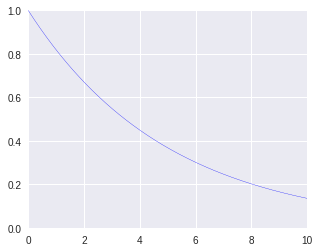

In [0]:
lin_plot(vs, None, [0,10], [0,1])

We also want the profile to be noisy, so here's how we'll add some noise to it.

In [0]:
noise = noise_amp * torch.randn(length)

In [0]:
ys_noisy = ys.add(noise).clamp(*y_interval)

In [0]:
vs = torch.stack([torch.Tensor(xs),ys_noisy]).transpose(0,1); vs.shape

torch.Size([10000, 2])

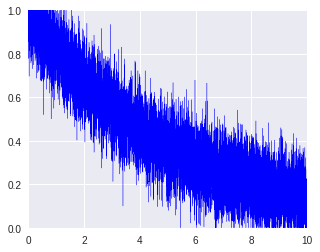

In [0]:
lin_plot(vs, None, [0,10], [0,1])

Now we need to add gaps in the data.   We'll start by generating integers that represent the number of gaps in each profile.

In [0]:
num_gaps = np.stack([np.random.normal(avg_gaps,std_gaps,data_sz).astype(int),np.zeros((data_sz,),dtype=int)]).max(0); num_gaps[0:10]

array([0, 3, 0, 0, 1, 2, 0, 1, 0, 0])

Each gap is generated randomly as below.  `interval` is the total (fake) time interval on which the data is defined, `avg_size` is the nominal average size desired for gaps, but not quite because we will arbitrarily truncate the randomly generated gaps to exist only on the appropriate time interval (which shortens the actual average) and sometimes the gaps will overlap and be effectively a single gap (which increases the actual average).

The function returns the start and end of the gap (in terms of the time axis), and the factor by which the data will be multiplied (between 0 and .8).

In [0]:
def random_gap(interval, avg_size):
  low,high = interval
  middle = np.random.uniform(low,high)
  size = np.abs(np.random.normal(0.,avg_size))
  start = max(middle-size/2,low)
  end   = min(middle+size/2,high)
  drop_factor = np.random.uniform(*mult_range)
  return start,end,drop_factor

In [0]:
random_gap(interval,avg_size=1) # Start x-value, end x-value, multiplication factor.

(6.060007484244158, 7.6632093302160165, 0.10342018689542076)

The above will be passed to our new `ItemList` class.  Now we need a way to take a curve and add the gaps...

In [0]:
def getmults(xs, gaplist):
  mults = torch.ones_like(xs)
  for gap in gaplist:
    start,end,mult = gap
    mask = (torch.lt((start*torch.ones_like(xs)),xs)*torch.lt(xs,(end*torch.ones_like(xs)))).to(dtype=torch.float32)
    mults =  mults * ((mask*mult) + (1.-mask))
  return mults  

...and a way to generate labels, i.e. which data points on the profile we want the model to identify as gaps.

In [0]:
def getlabels(xs, gaplist):
  labels = torch.zeros_like(xs)
  for gap in gaplist:
    start,end,mult = gap
    mask = (torch.lt((start*torch.ones_like(xs)),xs)*torch.lt(xs,(end*torch.ones_like(xs)))).to(dtype=torch.float32)
    labels = labels + mask
  return 1.-labels.clamp(0.,1.)

Here's a sample of what we'll multiply a profile by, elementwise.  First create a list of gaps then generate the multipliers.

In [0]:
gaplist = [(7.895473695650945, 8.5611717232079, 0.7412393215396834),
 (9.42338378189132, 10.0, 0.49183629537436746),
 (3.267080298267579, 4.566375305422216, 0.7222552666207067)]

In [0]:
%time mults = getmults(xs,gaplist)

CPU times: user 1.53 ms, sys: 482 µs, total: 2.01 ms
Wall time: 1.71 ms


Now let's incorporate the gaps in our sample profile.

In [0]:
ys_gaps = (ys*mults).add(noise).clamp(*y_interval)

In [0]:
vs = to_np(torch.stack([torch.Tensor(xs),ys_gaps]).transpose(0,1)); vs.shape

(10000, 2)

Here's the result, with a demo of labelling.  Gaps are indicated in red, non-gaps in blue.

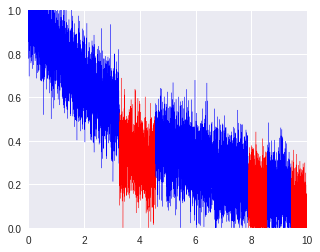

In [0]:
lin_plot(vs, getlabels(xs,gaplist), [0,10], [0,1])

## Generate dataset

This is what we'll store in the dataset to generate the gaps.

In [0]:
gaps = [[random_gap(interval,avg_size) for i in range(n)] for n in num_gaps]

In [0]:
a_list = np.random.uniform(*a_range,data_sz)
b_list = np.random.uniform(*b_range,data_sz)
k_list = np.random.uniform(*k_range,data_sz)
profile_params = np.array( list(zip(list(zip(list(a_list),list(b_list),list(k_list))),gaps)) )

In [0]:
items = array(gaps, dtype=object)

## An ItemList to handle the data in fast.ai

The `ProfileItemList` (subclassing a fast.ai wrapper for PyTorch datasets, sort of) will store the parameters for all profiles in (regular) memory and build and serve full profiles to the dataloader on the fly as PyTorch `Tensor`s, which will end up in GPU memory one batch at a time.  The noise is generated randomly, so the profile won't be exactly the same each time it's served, but this is fine (even desirable).

In [0]:
class ProfileLabelItemList(ItemList):

    def __init__(self, items, length=10000, interval=(0.,10.), **kwargs):
        super().__init__(items, **kwargs)
        self.length,self.interval = length,interval
        self.copy_new.append('length')
        self.copy_new.append('interval')
        
    def get(self, i): 
        xs,ys = getprofile(self.length,self.interval,*self.items[i][0])
        label = getlabels(xs,self.items[i][1])
        return label

In [0]:
class ProfileItemList(ItemList):
    _label_cls = ProfileLabelItemList

    def __init__(self, items, noise_amp=0.01, length=10000, interval=(0.,10.), **kwargs):
        super().__init__(items, **kwargs)
        self.noise_amp,self.length,self.interval = noise_amp,length,interval
        self.copy_new.append('length')
        self.copy_new.append('interval')
        self.copy_new.append('noise_amp')

    def get(self, i):
        noise = self.noise_amp * torch.randn(self.length)
        xs,ys = getprofile(self.length,self.interval,*self.items[i][0])
        mults = getmults(xs,self.items[i][1])
        return (ys*mults).add(noise).clamp(*y_interval).unsqueeze(0)

In [0]:
il = ProfileItemList(profile_params, noise_amp, length, interval)

In [0]:
labels = ProfileLabelItemList(profile_params, length, interval)

In [80]:
i = 1

il.items[i]

array([(1.2780566253593133, 0.28699739971043103, 0.11989891715300743),
       list([(6.183537904326836, 6.751093142291009, 0.3439988199246575), (2.9365144165846426, 4.471805087927873, 0.38723431479048387), (6.14921629659169, 7.362948266915738, 0.1860385923312481)])],
      dtype=object)

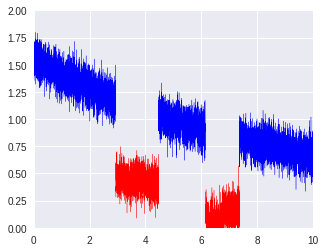

In [81]:
lin_plot(list(zip(xs,il[i].squeeze())),labels[i],[0,10],[0,2])

In [0]:
np.random.seed(5) # To prevent data leakage in case we happen to run this again without a fresh dataset.
valid_pct = .2

rand_idx = np.random.permutation(range(data_sz))
cut = int(valid_pct * data_sz)

ils,lils = il.split_by_idx(rand_idx[:cut]),labels.split_by_idx(rand_idx[:cut])

In [0]:
train,valid = LabelList(ils.train,lils.train),LabelList(ils.valid,lils.valid)

In [0]:
db = LabelLists('.',train,valid).databunch()

# Model

We will use a variation on the [U-net](https://arxiv.org/abs/1505.04597) model which was developed for image segmentation.  We are not processing images here, but we are trying to predict a mask on a 1-d set of data points, which is similar.  Therefore, we will use a 1-d convolutional model that uses an encoder/decoder structure with nested skip-connections.

In [0]:
# Parameter           # Value for best performer

bb_kernel_sz = 3      # 3
min_feat     = 16     # 16
max_feat     = 64     # 64
n_lay        = 6      # 6
scaling      = 2      # 2
add_mode     = True   # True
trans_ker    = 9      # 9

feats = [(min(max_feat, min_feat*(2 ** i)), min(max_feat, min_feat*(2 ** (i+1)))) for i in range(n_lay)]; feats

[(16, 32), (32, 64), (64, 64), (64, 64), (64, 64), (64, 64)]

## Framework

Much of the following was modified from the fast.ai library.

In [0]:
def _bn(ni, init_zero=False):
    "Batchnorm layer with 0 initialization"
    m = nn.BatchNorm1d(ni)
    m.weight.data.fill_(0 if init_zero else 1)
    m.bias.data.zero_()
    return m
  
def bn_relu_conv(ni, nf, ks, stride, init_zero=False):
    bn_initzero = _bn(ni, init_zero=init_zero)
    return nn.Sequential(bn_initzero, nn.ReLU(inplace=True), conv1d(ni, nf, ks, stride))

class BasicBlock(nn.Module):
    "Block from a wide ResNet."
    def __init__(self, ni, nf, ks, stride, drop_p=0.0):
        super().__init__()
        self.bn = nn.BatchNorm1d(ni)
        self.conv1 = conv1d(ni, nf, ks, stride)
        self.conv2 = bn_relu_conv(nf, nf, ks, 1)
        self.drop = nn.Dropout(drop_p, inplace=True) if drop_p else None
        self.shortcut = conv1d(ni, nf, 1, stride) if (ni != nf or stride != 1) else noop

    def forward(self, x):
        x2 = F.relu(self.bn(x), inplace=True)
        r = self.shortcut(x2)
        x = self.conv1(x2)
        if self.drop: x = self.drop(x)
        x = self.conv2(x) * 0.2
        return x.add_(r)

In [0]:
def conv1d(ni:int, no:int, ks:int=1, stride:int=1, padding=None, bias:bool=False):
    "Create and initialize `nn.Conv1d` layer."
    if padding is None: padding = ks//2
    conv = nn.Conv1d(ni, no, ks, stride=stride, padding=padding, bias=bias)
    nn.init.kaiming_normal_(conv.weight)
    if bias: conv.bias.data.zero_()
    return spectral_norm(conv)

In [0]:
class UnetBlock(nn.Module):
    "A quasi-UNet block, upsampling by using linear interpolation followed by convolution."
    def __init__(self, dn_in_c:int, dn_out_c:int, x_c:int, in_hook:Hook, out_hook:Hook, final_div:bool=True, 
                 blur:bool=False, leaky:float=None, self_attention:bool=False, add_mode=True):
        super().__init__()
        self.in_hook,self.out_hook = in_hook,out_hook
        self.bn = nn.BatchNorm1d(x_c)
        with torch.no_grad():
            self.bn.bias.fill_(1e-3)
            self.bn.weight.fill_(1.)
        
        conv_in = x_c if add_mode else 2*x_c
        
        self.conv1 = conv_layer(conv_in, dn_out_c, leaky=leaky, is_1d=True)
        self.conv2 = conv_layer(dn_out_c, dn_in_c, leaky=leaky, self_attention=self_attention, is_1d=True)
#         self.relu = relu(leaky=leaky)

    def forward(self, up_in:Tensor) -> Tensor:
        s = self.in_hook.stored
        ssh = s.shape[-1:]
        out_sz = self.out_hook.stored.shape[-1:]
#         up_out = F.interpolate(up_in, ssh, mode='linear')
        up_out = up_in
#         cat_x = self.relu(torch.cat([up_out, self.bn(s)], dim=1))
        cat_x = up_out + self.bn(s) if add_mode \
            else torch.cat([up_out, self.bn(s)], dim=1)
        
        return self.conv2(F.interpolate(self.conv1(cat_x),out_sz, mode='linear', align_corners=False))

In [0]:
class Noop_module(nn.Module): # Used to easily hook the raw input to the network
  def forward(self,x):
    return noop(x)

In [0]:
def sequentialize(l):
  return SequentialEx(*list(l))

## Construction

We now have the pieces needed to build the encoder and decoder.

### Encoder

In [0]:
enc_layers = [
              [BasicBlock(in_f,out_f,bb_kernel_sz,scaling),BasicBlock(out_f,out_f,bb_kernel_sz,1)]
              for (in_f,out_f) in feats
             ]

initial = Noop_module()
hook = hook_output(initial)

enc_layers = [[initial,BasicBlock(1,min_feat,9,2),BasicBlock(min_feat,min_feat,bb_kernel_sz,1)]] + enc_layers

enc = list(map(sequentialize, enc_layers))

In [0]:
encoder = SequentialEx(*enc)

### Transition

In [0]:
encoded_feats = feats[-1][1]

trans = BasicBlock(encoded_feats,encoded_feats,trans_ker,1)

### Decoder

For the decoder we construct the layers, hooking the outputs from the encoder layers as partial inputs.

In [0]:
sfs = hook_outputs(encoder)

dec_layers = [UnetBlock(out_f,in_f,in_f,in_hook,out_hook,add_mode=add_mode) 
              for (i,(out_f,in_f)),in_hook,out_hook in zip(enumerate(feats),sfs[1:],sfs[:-1])
             ]

last_in_f,last_out_f = 1,feats[0][0]
last_up = UnetBlock(last_out_f,last_out_f,last_out_f,sfs[0],hook,add_mode=add_mode)
last_conv = conv_layer(last_out_f, last_in_f, is_1d=True, use_activ=False)
sig = nn.Sigmoid()

dec_layers = list(reversed(dec_layers)) + [last_up,last_conv,sig]


In [0]:
decoder = SequentialEx(*dec_layers)

### Combined model

In [0]:
model = nn.Sequential(encoder,trans,decoder)

# Loss Function

For a loss function we use a variation on the DICE loss function (described [here](https://www.jeremyjordan.me/semantic-segmentation/#loss)).

In [0]:
def dice(preds,targs):
  return .5-((1.-preds.squeeze())*(1.-targs)).mean()/((1.-preds.squeeze()).mean()+(1.-targs).mean())

# Training

In [0]:
learn = Learner(db,model.cuda(),loss_func=dice)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


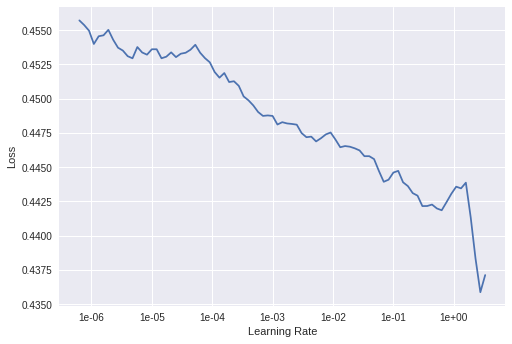

In [0]:
learn.recorder.plot()

In [54]:
learn.fit_one_cycle(8,max_lr=5e-2)

epoch,train_loss,valid_loss,time
0,0.074554,0.061635,05:29
1,0.040382,0.049042,05:29
2,0.019250,0.021283,05:27
3,0.021380,0.091546,05:29
4,0.007272,0.008852,05:25
5,0.005854,0.008339,05:23
6,0.003454,0.003389,05:22
7,0.002763,0.002545,05:30


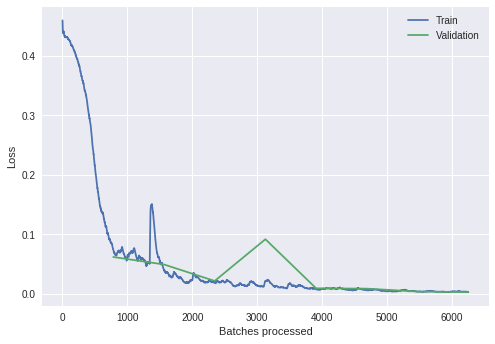

In [55]:
learn.recorder.plot_losses()

# Analysis

In [0]:
x,y = db.one_batch(ds_type=DatasetType.Valid)

The model is extemely accurate for almost all profiles:

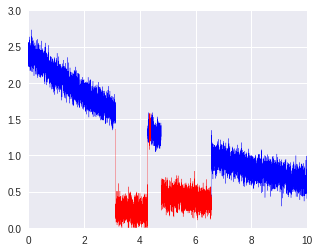

In [73]:
i = 2
lin_plot(list(zip(xs,x[i].squeeze())),learn.model(x[i].unsqueeze(0).cuda()).round().squeeze(),[0,10],[0,3]) # Predicted labels

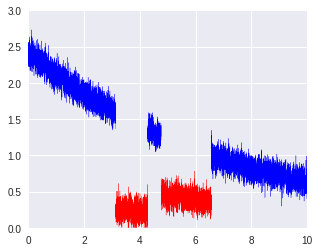

In [75]:
lin_plot(list(zip(xs,x[i].squeeze())),y[i].squeeze(),[0,10],[0,3]) # Actual labels

UPDATE: The model no longer falsely marks real data as fake.

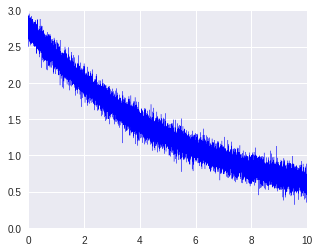

In [77]:
i = 3
lin_plot(list(zip(xs,x[i].squeeze())),learn.model(x[i].unsqueeze(0).cuda()).round().squeeze(),[0,10],[0,3]) # Predicted labels

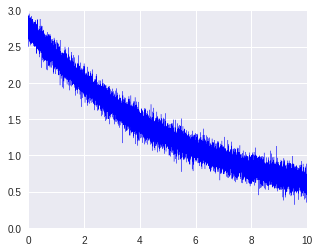

In [78]:
lin_plot(list(zip(xs,x[i].squeeze())),y[i].squeeze(),[0,10],[0,3]) # Actual labels

The model occasionally labels as fake some, but not all data points of particular gaps (but this is rare enough that I couldn't find an instance in the batch of 64 that I sampled).

# Conclusion

UPDATE: The performance of the model is excellent on the simulated data.  More information from the team would be needed to see whether the model would work as well on the real data.  Training on simulated data is generally a vulnerable process, and it would be preferrable to train on actual profiles, but it's unknown to me how much real data is available.  The model as it was demonstrated in this notebook had essentially unlimited data with which to train.  If real data is scarce, perhaps the real data could be analyzed to improve the quality of the simulated data to make it better for training.

Areas of potential improvement for the model are:

* Among various methods of implementing U-net style skip connections, addition and concatenation of the outputs of earlier layers with the input of the previous layer are common.  For this model, addition showed superior performance.  A hybrid method using concatenation but initializing the weights of the next layer to emulate an addition operation, could potentially give the performance of addition with the flexibility of concatenation.
* Experiment with integration of a recurrent network for better parsing of gap start and end positions.
* Integrate this model with the predictive model for single-pass training and prediction.

Hopefully this model can be helpful to the OAG data science team.